In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/breakhis/train/'
test_dir = "data/breakhis/test/"

extracted_features_dir = "extracted_features/"
model_name = "breakhis_mobilenet"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/breakhis/train/ 0
data/breakhis/train/benign 36224
data/breakhis/train/malignant 79168
******************************
data/breakhis/test/ 0
data/breakhis/test/benign 216
data/breakhis/test/malignant 481


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 86544 images belonging to 2 classes.
Found 28848 images belonging to 2 classes.
Found 697 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 86544
nb_validation_samples: 28848

predict_size_train: 2705
predict_size_validation: 902
nb_test_samples: 697
predict_size_test: 22

 num_classes: 2


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile

input_tensor = Input(shape = input_shape)  
model = MobileNet(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [11]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [12]:
# c1 = model.layers[4].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[7].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[12].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[17].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
bottleneck_final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 86544 samples, validate on 28848 samples
Epoch 1/1000
 - 10s - loss: 0.3809 - acc: 0.8321 - val_loss: 0.2848 - val_acc: 0.8851
Epoch 2/1000
 - 9s - loss: 0.2613 - acc: 0.8938 - val_loss: 0.2297 - val_acc: 0.9085
Epoch 3/1000
 - 9s - loss: 0.2105 - acc: 0.9160 - val_loss: 0.1962 - val_acc: 0.9218
Epoch 4/1000
 - 9s - loss: 0.1764 - acc: 0.9311 - val_loss: 0.1690 - val_acc: 0.9342
Epoch 5/1000
 - 9s - loss: 0.1517 - acc: 0.9421 - val_loss: 0.1492 - val_acc: 0.9423
Epoch 6/1000
 - 9s - loss: 0.1341 - acc: 0.9494 - val_loss: 0.1356 - val_acc: 0.9481
Epoch 7/1000
 - 9s - loss: 0.1193 - acc: 0.9546 - val_loss: 0.1319 - val_acc: 0.9502
Epoch 8/1000
 - 9s - loss: 0.1066 - acc: 0.9603 - val_loss: 0.1132 - val_acc: 0.9570
Epoch 9/1000
 - 9s - loss: 0.0974 - acc: 0.9640 - val_loss: 0.1138 - val_acc: 0.9560
Epoch 10/1000
 - 9s - loss: 0.0895 - acc: 0.9679 - val_loss: 0.1007 - val_acc: 0.9622
Epoch 11/1000
 - 9s - loss: 0.0809 - acc: 0.9703 - val_loss: 0.1127 - val_acc: 0.9587
Epoch 12/100

Epoch 96/1000
 - 9s - loss: 0.0182 - acc: 0.9953 - val_loss: 0.0882 - val_acc: 0.9818
Epoch 97/1000
 - 9s - loss: 0.0183 - acc: 0.9953 - val_loss: 0.0870 - val_acc: 0.9811
Epoch 98/1000
 - 9s - loss: 0.0196 - acc: 0.9948 - val_loss: 0.0861 - val_acc: 0.9811
Epoch 99/1000
 - 9s - loss: 0.0175 - acc: 0.9956 - val_loss: 0.0879 - val_acc: 0.9809
Epoch 100/1000
 - 9s - loss: 0.0202 - acc: 0.9952 - val_loss: 0.0910 - val_acc: 0.9805
Epoch 101/1000
 - 9s - loss: 0.0201 - acc: 0.9953 - val_loss: 0.0940 - val_acc: 0.9807
Epoch 102/1000
 - 9s - loss: 0.0213 - acc: 0.9949 - val_loss: 0.0834 - val_acc: 0.9824
Epoch 103/1000
 - 9s - loss: 0.0204 - acc: 0.9951 - val_loss: 0.0848 - val_acc: 0.9812
Epoch 104/1000
 - 9s - loss: 0.0199 - acc: 0.9954 - val_loss: 0.0847 - val_acc: 0.9802
Epoch 105/1000
 - 9s - loss: 0.0193 - acc: 0.9953 - val_loss: 0.1091 - val_acc: 0.9784
Epoch 106/1000
 - 9s - loss: 0.0195 - acc: 0.9952 - val_loss: 0.0966 - val_acc: 0.9809
Epoch 107/1000
 - 9s - loss: 0.0209 - acc: 0.99

Epoch 191/1000
 - 9s - loss: 0.0222 - acc: 0.9954 - val_loss: 0.1129 - val_acc: 0.9799
Epoch 192/1000
 - 9s - loss: 0.0213 - acc: 0.9957 - val_loss: 0.1148 - val_acc: 0.9795
Epoch 193/1000
 - 9s - loss: 0.0226 - acc: 0.9955 - val_loss: 0.1190 - val_acc: 0.9799
Epoch 194/1000
 - 9s - loss: 0.0245 - acc: 0.9951 - val_loss: 0.1099 - val_acc: 0.9803
Epoch 195/1000
 - 9s - loss: 0.0242 - acc: 0.9955 - val_loss: 0.1145 - val_acc: 0.9800
Epoch 196/1000
 - 9s - loss: 0.0236 - acc: 0.9953 - val_loss: 0.1153 - val_acc: 0.9800
Epoch 197/1000
 - 9s - loss: 0.0218 - acc: 0.9956 - val_loss: 0.1169 - val_acc: 0.9797
Epoch 198/1000
 - 9s - loss: 0.0207 - acc: 0.9958 - val_loss: 0.1155 - val_acc: 0.9798
Epoch 199/1000
 - 9s - loss: 0.0229 - acc: 0.9956 - val_loss: 0.1169 - val_acc: 0.9795
Epoch 200/1000
 - 9s - loss: 0.0209 - acc: 0.9957 - val_loss: 0.1122 - val_acc: 0.9803
Epoch 201/1000
 - 9s - loss: 0.0216 - acc: 0.9955 - val_loss: 0.1174 - val_acc: 0.9801
Epoch 202/1000
 - 9s - loss: 0.0213 - acc: 

 - 9s - loss: 0.0252 - acc: 0.9951 - val_loss: 0.1335 - val_acc: 0.9779
Epoch 286/1000
 - 9s - loss: 0.0256 - acc: 0.9951 - val_loss: 0.1340 - val_acc: 0.9786
Epoch 287/1000
 - 9s - loss: 0.0266 - acc: 0.9950 - val_loss: 0.1336 - val_acc: 0.9782
Epoch 288/1000
 - 9s - loss: 0.0247 - acc: 0.9950 - val_loss: 0.1370 - val_acc: 0.9787
Epoch 289/1000
 - 9s - loss: 0.0274 - acc: 0.9948 - val_loss: 0.1318 - val_acc: 0.9784
Epoch 290/1000
 - 9s - loss: 0.0262 - acc: 0.9952 - val_loss: 0.1341 - val_acc: 0.9783
Epoch 291/1000
 - 9s - loss: 0.0242 - acc: 0.9951 - val_loss: 0.1369 - val_acc: 0.9783
Epoch 292/1000
 - 9s - loss: 0.0267 - acc: 0.9946 - val_loss: 0.1338 - val_acc: 0.9783
Epoch 293/1000
 - 9s - loss: 0.0278 - acc: 0.9946 - val_loss: 0.1347 - val_acc: 0.9783
Epoch 294/1000
 - 9s - loss: 0.0269 - acc: 0.9949 - val_loss: 0.1318 - val_acc: 0.9780
Epoch 295/1000
 - 9s - loss: 0.0239 - acc: 0.9953 - val_loss: 0.1357 - val_acc: 0.9782
Epoch 296/1000
 - 9s - loss: 0.0231 - acc: 0.9955 - val_lo

Epoch 380/1000
 - 9s - loss: 0.0258 - acc: 0.9948 - val_loss: 0.1472 - val_acc: 0.9772
Epoch 381/1000
 - 9s - loss: 0.0282 - acc: 0.9946 - val_loss: 0.1469 - val_acc: 0.9770
Epoch 382/1000
 - 9s - loss: 0.0258 - acc: 0.9950 - val_loss: 0.1483 - val_acc: 0.9764
Epoch 383/1000
 - 9s - loss: 0.0299 - acc: 0.9944 - val_loss: 0.1491 - val_acc: 0.9770
Epoch 384/1000
 - 9s - loss: 0.0291 - acc: 0.9946 - val_loss: 0.1559 - val_acc: 0.9758
Epoch 385/1000
 - 9s - loss: 0.0308 - acc: 0.9944 - val_loss: 0.1463 - val_acc: 0.9764
Epoch 386/1000
 - 9s - loss: 0.0257 - acc: 0.9951 - val_loss: 0.1504 - val_acc: 0.9767
Epoch 387/1000
 - 9s - loss: 0.0280 - acc: 0.9945 - val_loss: 0.1527 - val_acc: 0.9764
Epoch 388/1000
 - 9s - loss: 0.0314 - acc: 0.9940 - val_loss: 0.1476 - val_acc: 0.9762
Epoch 389/1000
 - 9s - loss: 0.0291 - acc: 0.9948 - val_loss: 0.1519 - val_acc: 0.9759
Epoch 390/1000
 - 9s - loss: 0.0330 - acc: 0.9943 - val_loss: 0.1492 - val_acc: 0.9765
Epoch 391/1000
 - 9s - loss: 0.0285 - acc: 

 - 9s - loss: 0.0313 - acc: 0.9943 - val_loss: 0.1733 - val_acc: 0.9737
Epoch 475/1000
 - 9s - loss: 0.0315 - acc: 0.9942 - val_loss: 0.1620 - val_acc: 0.9748
Epoch 476/1000
 - 9s - loss: 0.0306 - acc: 0.9941 - val_loss: 0.1613 - val_acc: 0.9747
Epoch 477/1000
 - 9s - loss: 0.0331 - acc: 0.9941 - val_loss: 0.1655 - val_acc: 0.9745
Epoch 478/1000
 - 9s - loss: 0.0298 - acc: 0.9944 - val_loss: 0.1650 - val_acc: 0.9746
Epoch 479/1000
 - 9s - loss: 0.0302 - acc: 0.9944 - val_loss: 0.1702 - val_acc: 0.9734
Epoch 480/1000
 - 9s - loss: 0.0310 - acc: 0.9945 - val_loss: 0.1614 - val_acc: 0.9753
Epoch 481/1000
 - 9s - loss: 0.0346 - acc: 0.9936 - val_loss: 0.1638 - val_acc: 0.9753
Epoch 482/1000
 - 9s - loss: 0.0310 - acc: 0.9937 - val_loss: 0.1658 - val_acc: 0.9742
Epoch 483/1000
 - 9s - loss: 0.0321 - acc: 0.9940 - val_loss: 0.1651 - val_acc: 0.9739
Epoch 484/1000
 - 9s - loss: 0.0297 - acc: 0.9946 - val_loss: 0.1811 - val_acc: 0.9731
Epoch 485/1000
 - 9s - loss: 0.0322 - acc: 0.9942 - val_lo

Epoch 569/1000
 - 9s - loss: 0.0358 - acc: 0.9933 - val_loss: 0.1784 - val_acc: 0.9734
Epoch 570/1000
 - 9s - loss: 0.0355 - acc: 0.9936 - val_loss: 0.1823 - val_acc: 0.9722
Epoch 571/1000
 - 9s - loss: 0.0323 - acc: 0.9940 - val_loss: 0.1789 - val_acc: 0.9731
Epoch 572/1000
 - 9s - loss: 0.0314 - acc: 0.9939 - val_loss: 0.1848 - val_acc: 0.9717
Epoch 573/1000
 - 9s - loss: 0.0355 - acc: 0.9935 - val_loss: 0.1772 - val_acc: 0.9729
Epoch 574/1000
 - 9s - loss: 0.0367 - acc: 0.9933 - val_loss: 0.1734 - val_acc: 0.9730
Epoch 575/1000
 - 9s - loss: 0.0357 - acc: 0.9933 - val_loss: 0.1727 - val_acc: 0.9732
Epoch 576/1000
 - 9s - loss: 0.0353 - acc: 0.9936 - val_loss: 0.1904 - val_acc: 0.9712
Epoch 577/1000
 - 9s - loss: 0.0332 - acc: 0.9939 - val_loss: 0.1794 - val_acc: 0.9730
Epoch 578/1000
 - 9s - loss: 0.0354 - acc: 0.9937 - val_loss: 0.1906 - val_acc: 0.9719
Epoch 579/1000
 - 9s - loss: 0.0371 - acc: 0.9936 - val_loss: 0.1900 - val_acc: 0.9713
Epoch 580/1000
 - 9s - loss: 0.0350 - acc: 

 - 9s - loss: 0.0351 - acc: 0.9935 - val_loss: 0.1917 - val_acc: 0.9716
Epoch 664/1000
 - 9s - loss: 0.0375 - acc: 0.9936 - val_loss: 0.1902 - val_acc: 0.9714
Epoch 665/1000
 - 9s - loss: 0.0353 - acc: 0.9936 - val_loss: 0.1913 - val_acc: 0.9700
Epoch 666/1000
 - 9s - loss: 0.0350 - acc: 0.9935 - val_loss: 0.1929 - val_acc: 0.9714
Epoch 667/1000
 - 9s - loss: 0.0369 - acc: 0.9935 - val_loss: 0.2008 - val_acc: 0.9703
Epoch 668/1000
 - 9s - loss: 0.0381 - acc: 0.9929 - val_loss: 0.2036 - val_acc: 0.9700
Epoch 669/1000
 - 9s - loss: 0.0357 - acc: 0.9936 - val_loss: 0.1961 - val_acc: 0.9706
Epoch 670/1000
 - 9s - loss: 0.0364 - acc: 0.9932 - val_loss: 0.1952 - val_acc: 0.9711
Epoch 671/1000
 - 9s - loss: 0.0336 - acc: 0.9936 - val_loss: 0.2005 - val_acc: 0.9709
Epoch 672/1000
 - 9s - loss: 0.0365 - acc: 0.9936 - val_loss: 0.1983 - val_acc: 0.9707
Epoch 673/1000
 - 9s - loss: 0.0390 - acc: 0.9929 - val_loss: 0.1904 - val_acc: 0.9716
Epoch 674/1000
 - 9s - loss: 0.0368 - acc: 0.9934 - val_lo

Epoch 758/1000
 - 9s - loss: 0.0430 - acc: 0.9926 - val_loss: 0.2115 - val_acc: 0.9686
Epoch 759/1000
 - 10s - loss: 0.0396 - acc: 0.9928 - val_loss: 0.2110 - val_acc: 0.9686
Epoch 760/1000
 - 9s - loss: 0.0398 - acc: 0.9931 - val_loss: 0.2083 - val_acc: 0.9689
Epoch 761/1000
 - 9s - loss: 0.0392 - acc: 0.9926 - val_loss: 0.2269 - val_acc: 0.9670
Epoch 762/1000
 - 9s - loss: 0.0407 - acc: 0.9928 - val_loss: 0.2068 - val_acc: 0.9694
Epoch 763/1000
 - 9s - loss: 0.0383 - acc: 0.9932 - val_loss: 0.2068 - val_acc: 0.9691
Epoch 764/1000
 - 9s - loss: 0.0409 - acc: 0.9928 - val_loss: 0.2193 - val_acc: 0.9675
Epoch 765/1000
 - 9s - loss: 0.0364 - acc: 0.9933 - val_loss: 0.2173 - val_acc: 0.9678
Epoch 766/1000
 - 9s - loss: 0.0364 - acc: 0.9933 - val_loss: 0.2117 - val_acc: 0.9690
Epoch 767/1000
 - 9s - loss: 0.0411 - acc: 0.9928 - val_loss: 0.2180 - val_acc: 0.9676
Epoch 768/1000
 - 9s - loss: 0.0389 - acc: 0.9930 - val_loss: 0.2033 - val_acc: 0.9686
Epoch 769/1000
 - 9s - loss: 0.0386 - acc:

 - 9s - loss: 0.0434 - acc: 0.9927 - val_loss: 0.2186 - val_acc: 0.9668
Epoch 853/1000
 - 9s - loss: 0.0401 - acc: 0.9929 - val_loss: 0.2590 - val_acc: 0.9631
Epoch 854/1000
 - 9s - loss: 0.0414 - acc: 0.9924 - val_loss: 0.2227 - val_acc: 0.9667
Epoch 855/1000
 - 9s - loss: 0.0409 - acc: 0.9928 - val_loss: 0.2234 - val_acc: 0.9669
Epoch 856/1000
 - 9s - loss: 0.0399 - acc: 0.9930 - val_loss: 0.2184 - val_acc: 0.9682
Epoch 857/1000
 - 9s - loss: 0.0426 - acc: 0.9927 - val_loss: 0.2241 - val_acc: 0.9663
Epoch 858/1000
 - 9s - loss: 0.0437 - acc: 0.9922 - val_loss: 0.2197 - val_acc: 0.9681
Epoch 859/1000
 - 9s - loss: 0.0407 - acc: 0.9928 - val_loss: 0.2261 - val_acc: 0.9662
Epoch 860/1000
 - 9s - loss: 0.0400 - acc: 0.9932 - val_loss: 0.2282 - val_acc: 0.9657
Epoch 861/1000
 - 9s - loss: 0.0391 - acc: 0.9931 - val_loss: 0.2272 - val_acc: 0.9667
Epoch 862/1000
 - 9s - loss: 0.0426 - acc: 0.9925 - val_loss: 0.2244 - val_acc: 0.9664
Epoch 863/1000
 - 9s - loss: 0.0409 - acc: 0.9925 - val_lo

Epoch 947/1000
 - 9s - loss: 0.0453 - acc: 0.9923 - val_loss: 0.2331 - val_acc: 0.9651
Epoch 948/1000
 - 9s - loss: 0.0425 - acc: 0.9925 - val_loss: 0.2410 - val_acc: 0.9641
Epoch 949/1000
 - 9s - loss: 0.0422 - acc: 0.9926 - val_loss: 0.2360 - val_acc: 0.9651
Epoch 950/1000
 - 9s - loss: 0.0425 - acc: 0.9926 - val_loss: 0.2271 - val_acc: 0.9655
Epoch 951/1000
 - 9s - loss: 0.0426 - acc: 0.9925 - val_loss: 0.2435 - val_acc: 0.9642
Epoch 952/1000
 - 9s - loss: 0.0439 - acc: 0.9923 - val_loss: 0.2335 - val_acc: 0.9642
Epoch 953/1000
 - 9s - loss: 0.0453 - acc: 0.9918 - val_loss: 0.2427 - val_acc: 0.9636
Epoch 954/1000
 - 9s - loss: 0.0410 - acc: 0.9927 - val_loss: 0.2410 - val_acc: 0.9637
Epoch 955/1000
 - 9s - loss: 0.0453 - acc: 0.9922 - val_loss: 0.2341 - val_acc: 0.9647
Epoch 956/1000
 - 9s - loss: 0.0429 - acc: 0.9925 - val_loss: 0.2410 - val_acc: 0.9640
Epoch 957/1000
 - 9s - loss: 0.0436 - acc: 0.9923 - val_loss: 0.2397 - val_acc: 0.9645
Epoch 958/1000
 - 9s - loss: 0.0435 - acc: 

In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9239598278335724


Confusion Matrix
[[191  25]
 [ 28 453]]


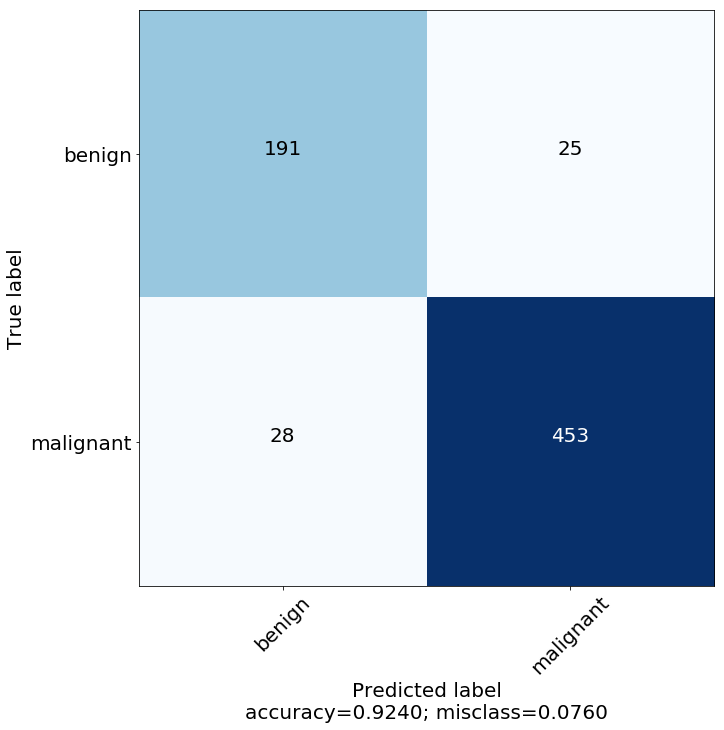

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[191  25]
 [ 28 453]]
              precision    recall  f1-score   support

      benign       0.87      0.88      0.88       216
   malignant       0.95      0.94      0.94       481

   micro avg       0.92      0.92      0.92       697
   macro avg       0.91      0.91      0.91       697
weighted avg       0.92      0.92      0.92       697



In [21]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  87.21461187214612
Specificity :  94.76987447698745


In [22]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.9099224317456679


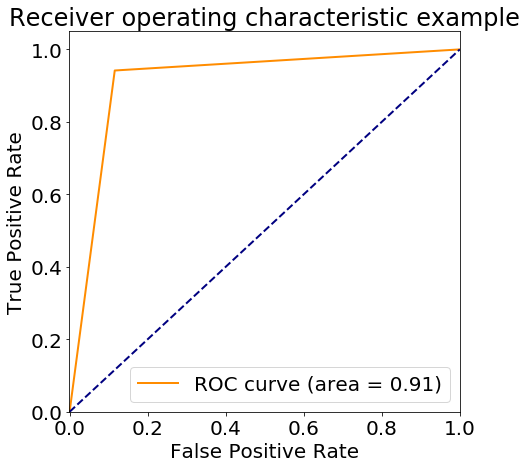

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [24]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

697/697 [==============================] - 0s 49us/step


In [25]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [26]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

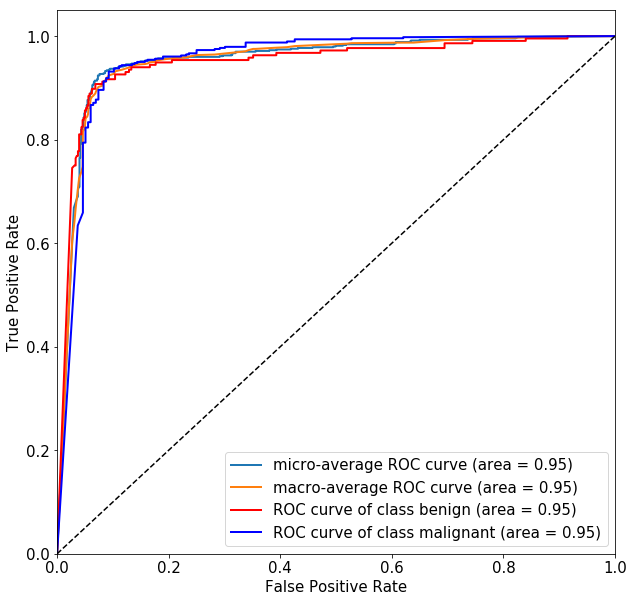

In [27]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [28]:
tn, fp, fn, tp = cm.ravel()

In [29]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.9239598278335724
Precision: 0.9476987447698745
Recall: 0.9417879417879418
tp: 453
fp: 25
tn: 191
fn: 28


In [30]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.9447340980187695


In [31]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.9447340980187696


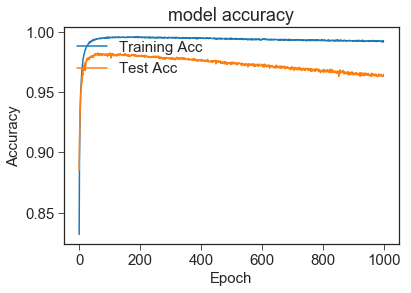

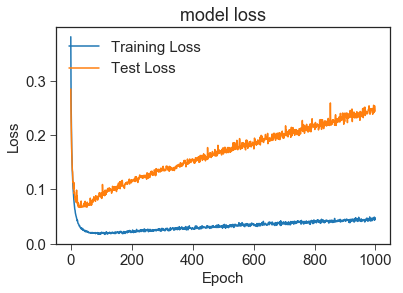

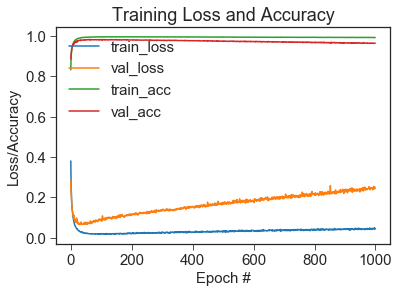

In [32]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")